# 1. Introduction
Objectif du notebook

Description rapide du dataset (Cityscapes, 8 classes)

Contexte embarqué (besoins de performance, taille, etc.)



# 2. Imports & Configuration
Import des bibliothèques (TensorFlow, Keras, albumentations, etc.)

Définition des constantes (dimensions, chemins, classes cibles)

Configuration GPU (si nécessaire)

In [64]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image


# 3. Chargement des données
Récupération des chemins des images et masques

Filtrage pour ne garder que les 8 classes principales

Fonction de lecture des images et masques

Visualisation d'exemples

In [65]:
# Dossier racine
base_path = "../data"

# Exemple avec une image de validation
city = "frankfurt"
image_name = "frankfurt_000000_000294_leftImg8bit.png"

# Chemins
image_path = os.path.join(base_path, "leftImg8bit", "val", city, image_name)
mask_path = os.path.join(base_path, "gtFine", "val", city, image_name.replace("leftImg8bit", "gtFine_labelIds"))

# Chargement
image = Image.open(image_path)
mask = Image.open(mask_path)

# Conversion en array
image_np = np.array(image)
mask_np = np.array(mask)


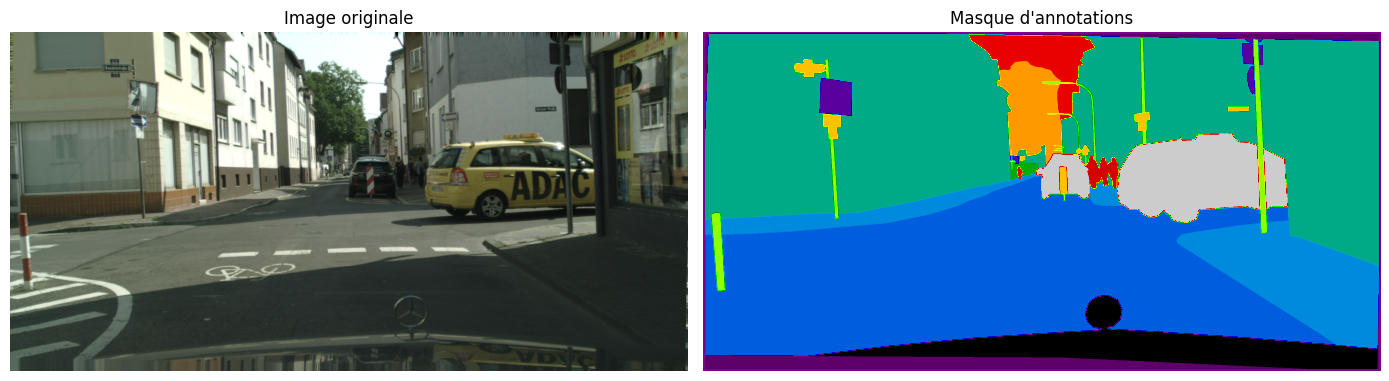

In [66]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.title("Image originale")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask_np, cmap='nipy_spectral')  # colormap perceptuelle
plt.title("Masque d'annotations")
plt.axis("off")

plt.tight_layout()
plt.show()


In [67]:
def afficher_batch_images_avec_masks(base_path, split='val', ville='frankfurt', nb_images=5):
    import random

    img_dir = os.path.join(base_path, "leftImg8bit", split, ville)
    mask_dir = os.path.join(base_path, "gtFine", split, ville)

    # On récupère toutes les images disponibles dans la ville
    all_images = [f for f in os.listdir(img_dir) if f.endswith("_leftImg8bit.png")]
    
    # Sélection aléatoire
    images_choisies = random.sample(all_images, min(nb_images, len(all_images)))

    plt.figure(figsize=(14, 4 * nb_images))

    for i, nom_image in enumerate(images_choisies):
        img_path = os.path.join(img_dir, nom_image)
        mask_path = os.path.join(mask_dir, nom_image.replace("leftImg8bit", "gtFine_labelIds"))

        image = np.array(Image.open(img_path))
        mask = np.array(Image.open(mask_path))

        plt.subplot(nb_images, 2, i * 2 + 1)
        plt.imshow(image)
        plt.title(f"Image {i+1} - {nom_image}")
        plt.axis("off")

        plt.subplot(nb_images, 2, i * 2 + 2)
        plt.imshow(mask, cmap='nipy_spectral')
        plt.title(f"Masque {i+1}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


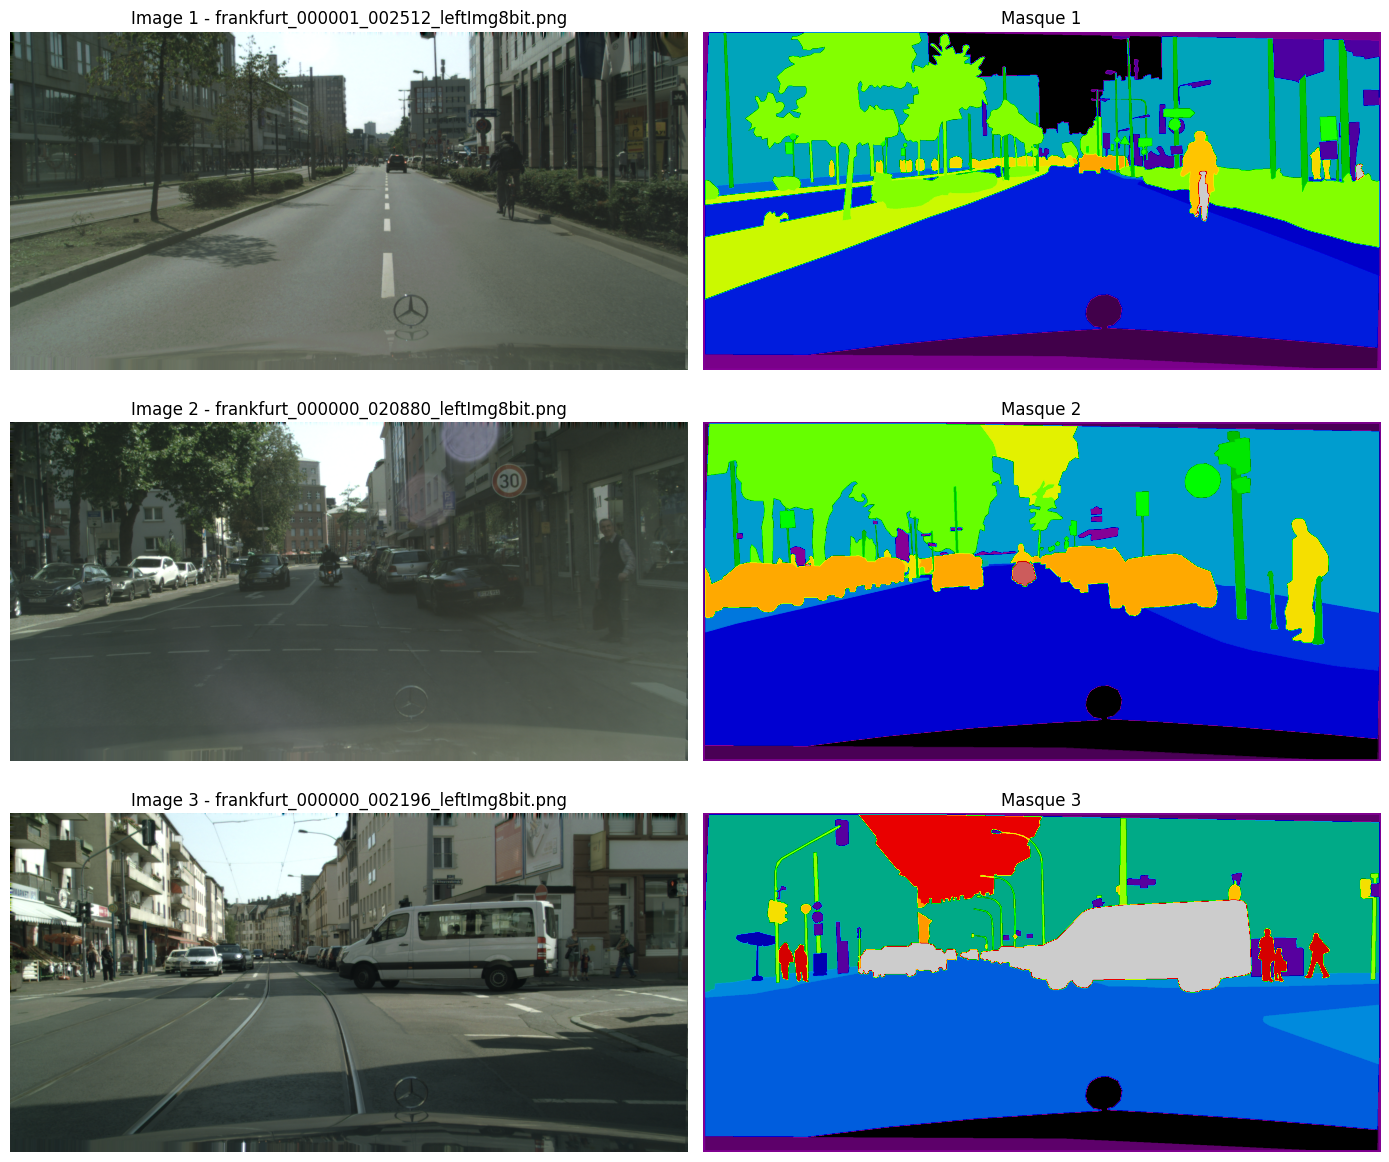

In [68]:
afficher_batch_images_avec_masks(base_path="../data", split="val", ville="frankfurt", nb_images=3)


# 4. Prétraitement et Augmentation
Redimensionnement, normalisation

Pipeline de data augmentation (albumentations)

Création d’un tf.data.Dataset ou Sequence personnalisé

Affichage d’exemples augmentés



In [69]:
def group_labels_to_8(mask):
    label_mapping = {
        # flat
        7: 0, 8: 0, 9: 7, 10: 7,  # road, sidewalk, parking, rail track

        # human
        24: 1, 25: 1,  # person, rider

        # vehicle
        26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 2, 33: 2,  # car, truck, bus, train, motorcycle, etc.

        # construction
        11: 3, 12: 3, 13: 3, 14: 3, 15: 3, 16: 3, 17: 4,  # building, wall, fence, etc.

        # object
        18: 4, 19: 4, 20: 4,  # pole, traffic light/sign

        # nature
        21: 5, 22: 5,  # vegetation, terrain

        # sky
        23: 6,  # sky

        # void (tout le reste → 7)
    }

    mapped = np.full_like(mask, 7)  # 7 = classe "void" par défaut
    for src, dst in label_mapping.items():
        mapped[mask == src] = dst
    return mapped


In [70]:
import cv2

def enhance_contrast_rgb(image):
    img_yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    img_yuv[..., 0] = cv2.equalizeHist(img_yuv[..., 0])  # Histogram equalization sur Y
    return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

In [71]:
def preprocess(image, mode="baseline"):
    if mode == "contrast":
        image = enhance_contrast_rgb(image)

    elif mode == "edges":
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        edges = cv2.Canny(gray, 100, 200)
        edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)  # 3 canaux

        # 🧠 Assure-toi que les types sont les mêmes (uint8)
        if image.dtype != edges.dtype:
            edges = edges.astype(image.dtype)

        # ➕ Fusion des images
        image = cv2.addWeighted(image, 0.8, edges, 0.2, 0)


    image = image / 255.0
    return image


In [93]:
import keras
import os
import numpy as np
from PIL import Image
import albumentations as A
from albumentations.core.composition import OneOf
from albumentations.pytorch import ToTensorV2

class CityscapesGenerator(keras.utils.Sequence):
    def __init__(self, image_paths, mask_paths, batch_size=8, image_size=(256, 512),
                 augment=False, shuffle=True, preprocess_mode="baseline"):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.image_size = image_size
        self.augment = augment
        self.shuffle = shuffle
        self.preprocess_mode = preprocess_mode
        self.on_epoch_end()

        self.transform = self._get_transform()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = []
        batch_masks = []

        for i in batch_indices:
            image = np.array(Image.open(self.image_paths[i]))
            mask = np.array(Image.open(self.mask_paths[i]))
            mask = group_labels_to_8(mask)  # 🎯 remapping ici
            image = preprocess(image, mode=self.preprocess_mode)
            image = image.astype(np.float32)
            if self.augment:
                transformed = self.transform(image=image, mask=mask)
                image = transformed["image"]
                mask = transformed["mask"]

            image = image / 255.0
            image = cv2.resize(image, (self.image_size[1], self.image_size[0]))
            mask = cv2.resize(mask, (self.image_size[1], self.image_size[0]), interpolation=cv2.INTER_NEAREST)


            batch_images.append(image)
            batch_masks.append(mask)


        return np.array(batch_images), np.array(batch_masks)

    def _get_transform(self):
        if not self.augment:
            return A.Compose([])

        return A.Compose([
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.3),
            A.RandomGamma(p=0.3),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.5),
            A.GaussNoise(var_limit=(10.0, 50.0), mean=0, p=0.3),
            A.MotionBlur(p=0.2),
            A.HueSaturationValue(p=0.3),
        ])



In [73]:
def get_image_and_mask_paths(base_path, split="train", ville="aachen"):
    import glob

    img_dir = os.path.join(base_path, "leftImg8bit", split, ville)
    mask_dir = os.path.join(base_path, "gtFine", split, ville)

    # Liste uniquement les images leftImg8bit
    image_paths = sorted(glob.glob(os.path.join(img_dir, "*_leftImg8bit.png")))

    # Pour chaque image, construit le chemin du masque _labelIds
    mask_paths = [
        os.path.join(mask_dir, os.path.basename(p).replace("leftImg8bit", "gtFine_labelIds"))
        for p in image_paths
    ]
    return image_paths, mask_paths




In [74]:
img_paths, mask_paths = get_image_and_mask_paths("../data", split="train", ville="aachen")
print(img_paths[0])
print(mask_paths[0])


../data\leftImg8bit\train\aachen\aachen_000000_000019_leftImg8bit.png
../data\gtFine\train\aachen\aachen_000000_000019_gtFine_labelIds.png


In [75]:
gen1 = CityscapesGenerator(img_paths, mask_paths, preprocess_mode='baseline')
gen2 = CityscapesGenerator(img_paths, mask_paths, preprocess_mode='contrast')
gen3 = CityscapesGenerator(img_paths, mask_paths, preprocess_mode='edges')

X_batch, y_batch = gen1[0]


print("Shape images :", X_batch.shape)
print("Shape masques :", y_batch.shape)


Shape images : (8, 256, 512, 3)
Shape masques : (8, 256, 512)


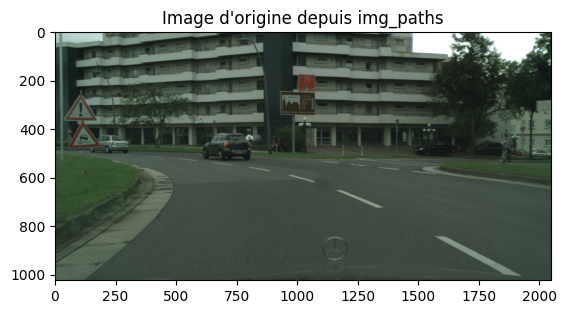

In [80]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

i = 0
raw_img = np.array(Image.open(img_paths[i]))

plt.imshow(raw_img)
plt.title("Image d'origine depuis img_paths")
plt.show()


In [81]:
print("X1[0] min/max :", X1[0].min(), X1[0].max())
print("X2[0] min/max :", X2[0].min(), X2[0].max())
print("X3[0] min/max :", X3[0].min(), X3[0].max())


X1[0] min/max : 0.00019223375624759708 0.00392156862745098
X2[0] min/max : 0.0 0.00392156862745098
X3[0] min/max : 0.000130718954248366 0.0034755863129565553


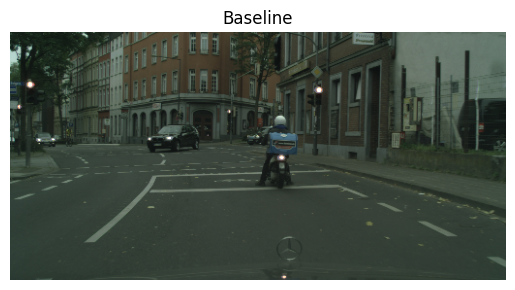

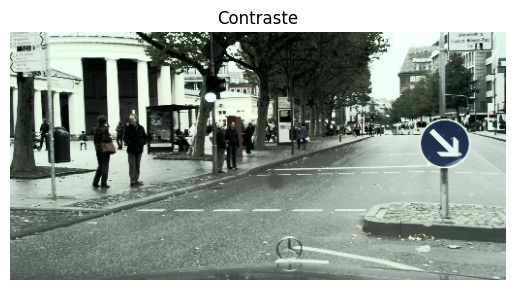

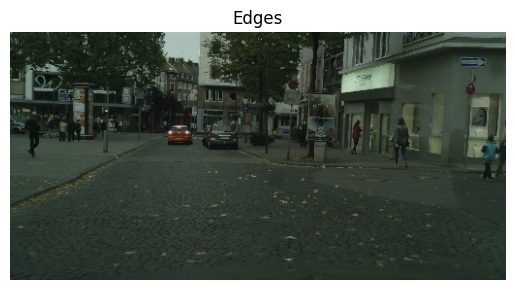

In [83]:
import matplotlib.pyplot as plt

# On récupère le même index dans chaque générateur
i = 0
X1, y = gen1[i]
X2, _ = gen2[i]
X3, _ = gen3[i]

for img, title in zip([X1[0], X2[0], X3[0]], ["Baseline", "Contraste", "Edges"]):
    plt.figure()
    plt.imshow(img / img.max())
    plt.title(title)
    plt.axis('off')
    plt.show()



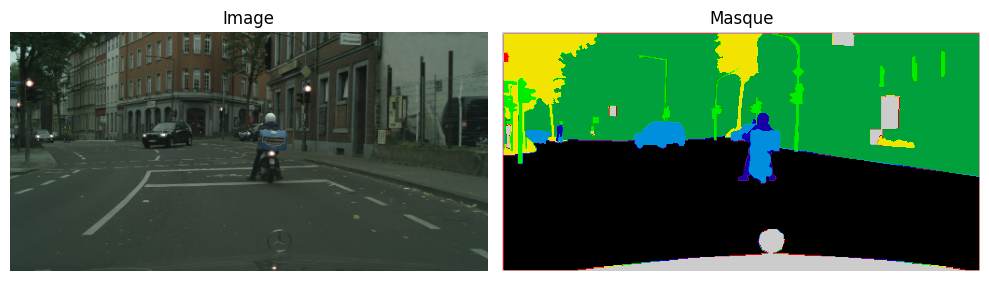

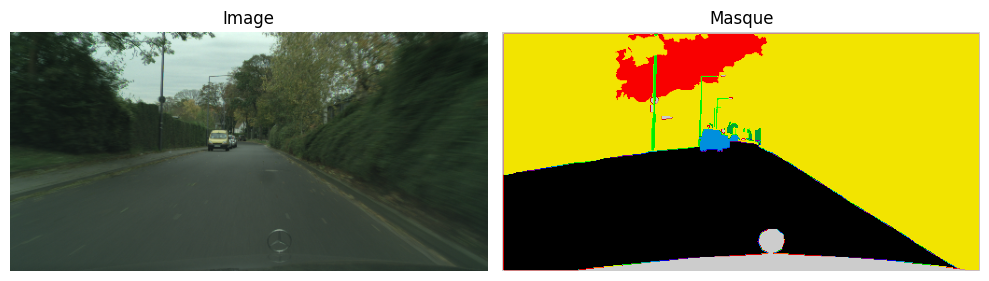

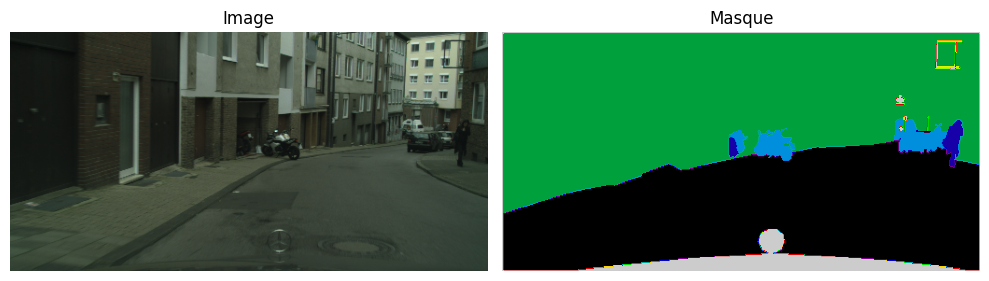

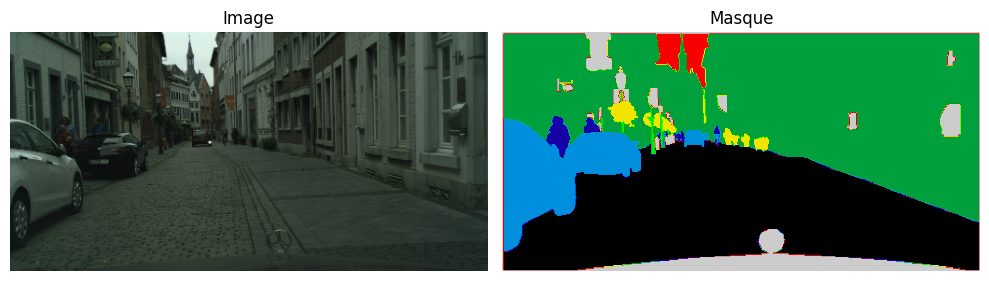

In [85]:
for i in range(4):
    plt.figure(figsize=(10, 4))

    # Image normalisée (évite l'image noire)
    plt.subplot(1, 2, 1)
    plt.imshow(X_batch[i] / X_batch[i].max())  # ou vmin=0, vmax=0.01
    plt.title("Image")
    plt.axis("off")

    # Masque
    plt.subplot(1, 2, 2)
    plt.imshow(y_batch[i], cmap="nipy_spectral")
    plt.title("Masque")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


# 5. Modélisation
Définition du modèle (U-Net, DeepLabV3+, etc.)

Ajout d’une fonction de perte personnalisée (Dice loss + CrossEntropy)

Compilation du modèle avec les bonnes métriques (IoU, accuracy, etc.)

In [94]:
train_img, train_mask = get_image_and_mask_paths("../data", "train", "aachen")
val_img, val_mask = get_image_and_mask_paths("../data", "val", "frankfurt")

train_gen = CityscapesGenerator(train_img, train_mask, batch_size=4, image_size=(256, 512), augment=True)
val_gen = CityscapesGenerator(val_img, val_mask, batch_size=4, image_size=(256, 512), augment=False)


C:\Users\misss\AppData\Local\Temp\ipykernel_5484\3689742338.py:67: UserWarning: Argument(s) 'var_limit, mean' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), mean=0, p=0.3),


In [95]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

callbacks = [
    ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True, verbose=1),
    EarlyStopping(monitor="val_loss", patience=3, verbose=1, restore_best_weights=True)
]


In [96]:
from tensorflow.keras import layers, models

def unet_model(input_shape=(256, 512, 3), num_classes=8):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u5 = layers.UpSampling2D((2, 2))(c4)
    u5 = layers.Concatenate()([u5, c3])
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u6 = layers.UpSampling2D((2, 2))(c5)
    u6 = layers.Concatenate()([u6, c2])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.UpSampling2D((2, 2))(c6)
    u7 = layers.Concatenate()([u7, c1])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c7)

    return models.Model(inputs=inputs, outputs=outputs)


In [97]:
gen_baseline = CityscapesGenerator(train_img, train_mask, batch_size=4, image_size=(256, 512), augment=True, preprocess_mode='baseline')
gen_contrast = CityscapesGenerator(train_img, train_mask, batch_size=4, image_size=(256, 512), augment=True, preprocess_mode='contrast')
gen_edges    = CityscapesGenerator(train_img, train_mask, batch_size=4, image_size=(256, 512), augment=True, preprocess_mode='edges')


C:\Users\misss\AppData\Local\Temp\ipykernel_5484\3689742338.py:67: UserWarning: Argument(s) 'var_limit, mean' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), mean=0, p=0.3),


In [ ]:
results = {}

for mode, gen in zip(['baseline', 'contrast', 'edges'], [gen_baseline, gen_contrast, gen_edges]):
    print(f"🔧 Entraînement avec prétraitement: {mode}")
    
    model = unet_model(input_shape=(256, 512, 3), num_classes=8)
    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])

    history = model.fit(
        gen,
        validation_data=val_gen,
        epochs=1,  # ou plus si tu veux observer
        callbacks=callbacks,
        verbose=1
    )
    
    results[mode] = (model, history)


🔧 Entraînement avec prétraitement: baseline
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3158 - loss: 2.1409
Epoch 1: val_loss improved from inf to 1.73758, saving model to best_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 416s 9s/step - accuracy: 0.3166 - loss: 2.1347 - val_accuracy: 0.3880 - val_loss: 1.7376
Restoring model weights from the end of the best epoch: 1.
🔧 Entraînement avec prétraitement: contrast
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3695 - loss: 2.1627
Epoch 1: val_loss improved from 1.73758 to 1.70425, saving model to best_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 431s 10s/step - accuracy: 0.3702 - loss: 2.1561 - val_accuracy: 0.3880 - val_loss: 1.7043
Restoring model weights from the end of the best epoch: 1.
🔧 Entraînement avec prétraitement: edges
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.3163 - loss: 1.8328
Epoch 1: val_loss did not improve from 1.70425
44/44 ━━━━━━━━━━━━━━━━━━━━ 439s 10s/step - accuracy: 0.3175 - loss: 1.8297 - val_accuracy: 0.3880 - val_loss: 1.7176
Restoring model weights from the end of the best epoch: 1.


In [103]:
results[mode] = (model, history)

In [104]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
for mode, history in results.items():
    plt.plot(history.history['loss'], label=f"{mode} - train")
    plt.plot(history.history['val_loss'], linestyle='--', label=f"{mode} - val")

plt.title("Courbe de perte selon le prétraitement")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


AttributeError: 'tuple' object has no attribute 'history'

<Figure size 800x500 with 0 Axes>

In [106]:
# On récupère les bons modèles
model_baseline, _ = results['baseline']
model_contrast, _ = results['contrast']
model_edges, _ = results['edges']

# Et on affiche les prédictions
show_predictions(gen_baseline, model_baseline, "Baseline")
show_predictions(gen_contrast, model_contrast, "Contraste")
show_predictions(gen_edges, model_edges, "Edges")


KeyError: 'contrast'

In [ ]:
model = unet_model(input_shape=(256, 512, 3), num_classes=8)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
N = 200
train_img, train_mask = get_image_and_mask_paths("../data", "train", "aachen")
val_img, val_mask = get_image_and_mask_paths("../data", "val", "frankfurt")

train_img = train_img[:N]
train_mask = train_mask[:N]
val_img = val_img[:N]
val_mask = val_mask[:N]

train_gen = CityscapesGenerator(train_img, train_mask, batch_size=4, image_size=(256, 512), augment=True)
val_gen = CityscapesGenerator(val_img, val_mask, batch_size=4, image_size=(256, 512), augment=False)


C:\Users\misss\AppData\Local\Temp\ipykernel_20152\2239875030.py:64: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),


In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.4274 - loss: 1.4867
Epoch 1: val_loss did not improve from 1.58260
44/44 ━━━━━━━━━━━━━━━━━━━━ 389s 9s/step - accuracy: 0.4277 - loss: 1.4861 - val_accuracy: 0.3832 - val_loss: 1.6041
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5171 - loss: 1.3696
Epoch 2: val_loss improved from 1.58260 to 1.43599, saving model to best_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 384s 9s/step - accuracy: 0.5176 - loss: 1.3681 - val_accuracy: 0.5061 - val_loss: 1.4360
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5693 - loss: 1.2424
Epoch 3: val_loss improved from 1.43599 to 1.27531, saving model to best_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 385s 9s/step - accuracy: 0.5693 - loss: 1.2419 - val_accuracy: 0.5412 - val_loss: 1.2753
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5945 - loss: 1.1460
Epoch 4: val_loss did not improve from 1.27531
44/44 ━━━━━━━━━━━━━━━━━━━━ 384s 9s/step - accuracy: 0.5947 - loss: 1.1452 - val_accuracy: 0.5252 - val_loss: 1.4162
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6041 - loss: 1.0341
Epoch 5: val_loss improved from 1.27531 to 1.21174, saving model to best_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 386s 9s/step - accuracy: 0.6044 - loss: 1.0341 - val_accuracy: 0.5717 - val_loss: 1.2117
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6529 - loss: 0.9713
Epoch 6: val_loss did not improve from 1.21174
44/44 ━━━━━━━━━━━━━━━━━━━━ 386s 9s/step - accuracy: 0.6528 - loss: 0.9714 - val_accuracy: 0.5674 - val_loss: 1.3390
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6745 - loss: 0.9036
Epoch 7: val_loss improved from 1.21174 to 1.12104, saving model to best_model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 386s 9s/step - accuracy: 0.6741 - loss: 0.9049 - val_accuracy: 0.5847 - val_loss: 1.1210
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6607 - loss: 0.9347
Epoch 8: val_loss did not improve from 1.12104
44/44 ━━━━━━━━━━━━━━━━━━━━ 382s 9s/step - accuracy: 0.6609 - loss: 0.9343 - val_accuracy: 0.5925 - val_loss: 1.1895
Epoch 9/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6891 - loss: 0.8769
Epoch 9: val_loss did not improve from 1.12104
44/44 ━━━━━━━━━━━━━━━━━━━━ 383s 9s/step - accuracy: 0.6891 - loss: 0.8768 - val_accuracy: 0.5210 - val_loss: 1.4472
Epoch 10/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6727 - loss: 0.9009
Epoch 10: val_loss did not improve from 1.12104
44/44 ━━━━━━━━━━━━━━━━━━━━ 383s 9s/step - accuracy: 0.6729 - loss: 0.9007 - val_accuracy: 0.5855 - val_loss: 1.2083
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 7.


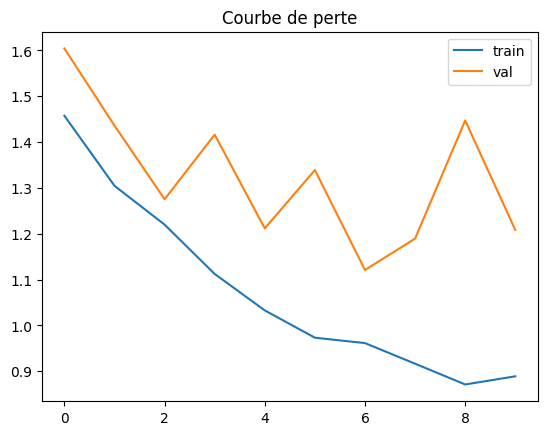

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Courbe de perte")
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


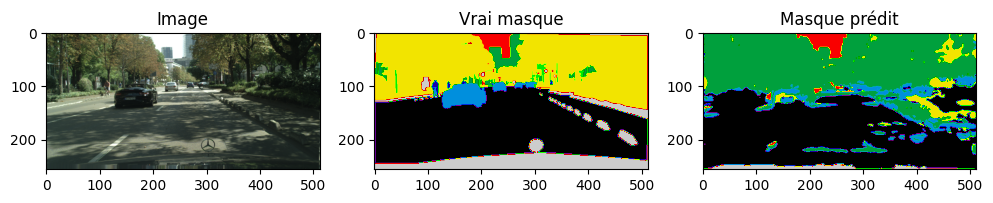

In [ ]:
X_val, y_val = val_gen[0]
y_pred = model.predict(X_val)

# Masques prévus : argmax sur les classes
y_pred_classes = np.argmax(y_pred, axis=-1)

# Visualisation d'un exemple
i = 0
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(X_val[i])
plt.title("Image")

plt.subplot(1, 3, 2)
plt.imshow(y_val[i], cmap="nipy_spectral")
plt.title("Vrai masque")

plt.subplot(1, 3, 3)
plt.imshow(y_pred_classes[i], cmap="nipy_spectral")
plt.title("Masque prédit")
plt.show()


In [ ]:
print("Valeurs présentes dans le vrai masque :", np.unique(y_val[i]))


Valeurs présentes dans le vrai masque : [0 1 2 3 4 5 6 7]


In [ ]:
print("Valeurs présentes dans le masque prédit :", np.unique(y_pred_classes[i]))


Valeurs présentes dans le masque prédit : [0 2 3 5 6 7]


# 6. Entraînement
Split train/val

Définition des callbacks (ModelCheckpoint, ReduceLROnPlateau, etc.)

Lancement de l'entraînement

Affichage des courbes d’évolution (loss, IoU, etc.)

# 7. Évaluation
Prédictions sur le set de validation

Affichage visuel des résultats (image, masque réel, masque prédit)

Calcul de métriques globales et par classe

# 8. Optimisation
Test d’autres architectures ou backbone (MobileNetV2, etc.)

Essais de réglages (batch size, learning rate)

Comparaison des performances



# 9. Conclusion
Résumé des résultats

Points forts et limites du modèle

Prochaines étapes (ex : export TFLite, intégration dans API, embarqué, etc.)